In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data/"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'test_post_competition.csv', 'test_labels.csv', 'test.csv', 'train.csv', 'train_post_competition.csv', 'sample_submission.csv']


# Análisis de un problema multilabel

Competencia original:

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

# EDA (Exploratory Data Analysis)

In [4]:
folder = './data/'

In [5]:
train = pd.read_csv(folder + "train.csv")
test = pd.read_csv(folder + "test.csv")
test_labels = pd.read_csv(folder + "test_labels.csv")
submission = pd.read_csv(folder + "sample_submission.csv")

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
# Cantidad de observaciones
train.shape

(159571, 8)

## Defino salida del modelo $y$

In [7]:
# Defino y (Salida del modelo)
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

print(y.shape)
print(y[:10])

(159571, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [8]:
# Dataset muy desbalanceado
toxic_ratio = (y.sum(axis = 1) > 0).sum() / y.shape[0]
print('Porcentaje de comentarios toxicos:', toxic_ratio)

Porcentaje de comentarios toxicos: 0.10167887648758234


In [9]:
# La mayoría son toxic
print(train[list_classes].sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [10]:
# Normalizo
print(train[list_classes].sum() / y.shape[0])

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64


In [11]:
# Superposición entre las clases (Multilabel)
for cl in list_classes[1:]:
    N = ((train['toxic'] == 0) & (train[cl] == 1)).sum()
    print(f'Es {cl} pero no es toxic:', N)

Es severe_toxic pero no es toxic: 0
Es obscene pero no es toxic: 523
Es threat pero no es toxic: 29
Es insult pero no es toxic: 533
Es identity_hate pero no es toxic: 103


Se puede ver aca por ejemplo que si es severe_toxic es si o si toxic, pero que insulto puede no ser tóxico por ejemplo

In [12]:
# Baseline (Suponer que siempre elijo zeros (No toxico))
1 - (train[list_classes].sum().values / len(train)).mean()

0.9633412921729722

In [13]:
((y == np.zeros_like(y)).sum(axis=0) / len(y)).mean()

0.9633412921729722

In [14]:
train[list_classes].sum().values / len(train)

array([0.09584448, 0.00999555, 0.05294822, 0.00299553, 0.04936361,
       0.00880486])

# Divido entre train y valid

In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train['comment_text'], y, test_size = 0.1)

print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(143613,) (15958,)
(143613, 6) (15958, 6)


# Armo TFIDF

Term Frequency Inverse Document Frequency

In [16]:
X_train[:10]

148723    If you want to file a report go ahead, just be...
12965     All new Wiki members have a right to edit==\n\...
92535     I don't recall claiming anyone was a bully? Th...
66305               I hate you. U are a homosapian. Breasts
6609      WCS \n\nThose things are painful. They take a ...
45733     ObRoy, I believe you don't understand english....
148033    Adamslinger, firstly I suggest you go back and...
111909    "\n\nHello! Please leave me new messages at th...
70479     "I would certainly suggest that the wording be...
112574    Image \n\nAdded image of map, it would be real...
Name: comment_text, dtype: object

In [17]:
raw_text_train = X_train.apply(str.lower)
raw_text_valid = X_valid.apply(str.lower)
raw_text_test = test["comment_text"].apply(str.lower)

In [18]:
print(raw_text_train[:10]) # Recordar que train_test_split hace shuffle 

148723    if you want to file a report go ahead, just be...
12965     all new wiki members have a right to edit==\n\...
92535     i don't recall claiming anyone was a bully? th...
66305               i hate you. u are a homosapian. breasts
6609      wcs \n\nthose things are painful. they take a ...
45733     obroy, i believe you don't understand english....
148033    adamslinger, firstly i suggest you go back and...
111909    "\n\nhello! please leave me new messages at th...
70479     "i would certainly suggest that the wording be...
112574    image \n\nadded image of map, it would be real...
Name: comment_text, dtype: object


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

max_features = 100000

tfidf_vectorizer = TfidfVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   stop_words='english')

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

CPU times: user 8.09 s, sys: 176 ms, total: 8.26 s
Wall time: 8.32 s


In [20]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

CPU times: user 852 ms, sys: 11.9 ms, total: 864 ms
Wall time: 864 ms


In [21]:
count_vectorizer = CountVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   stop_words='english')

%time count_matrix_train = count_vectorizer.fit_transform(raw_text_train)

CPU times: user 7.67 s, sys: 146 ms, total: 7.81 s
Wall time: 7.83 s


In [22]:
tfidf_matrix_train.shape, count_matrix_train.shape

((143613, 100000), (143613, 100000))

# Sparsity

In [23]:
sparsity = 1 - (tfidf_matrix_train > 0).sum() / (tfidf_matrix_train.shape[0] * tfidf_matrix_train.shape[1])
print(sparsity)

0.9997615839791663


# Resultados TFIDF

In [25]:
top_10 = np.argsort(tfidf_matrix_train.sum(axis=0))[0, ::-1][0, :10].tolist()[0]
feature_names = np.array(tfidf_vectorizer.get_feature_names())

print(feature_names[np.array(top_10)])

['thanks' 'edit' 'think' 'know' 'did' 'user' 'people' 'articles' 'use'
 'thank']


In [26]:
top_10_count = np.argsort(count_matrix_train.sum(axis=0))[0, ::-1][0, :10].tolist()[0]
feature_names_count = np.array(count_vectorizer.get_feature_names())

print(feature_names_count[np.array(top_10_count)])

['think' 'know' 'people' 'edit' 'articles' 'use' 'time' 'did' 'user'
 'thanks']


# PCA?...

In [30]:
from sklearn.decomposition import TruncatedSVD
# tf_idf_train_PCA
# tf_idf_valid_PCA
# tener los datos centrado alrededor de cero es lo mas util

trf = TruncatedSVD(100)
trf.fit(tfidf_matrix_train)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

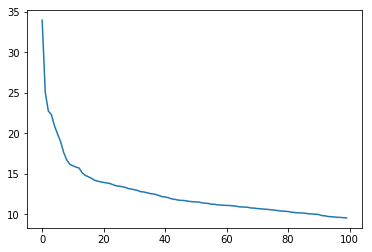

In [33]:
from matplotlib import pyplot as plt
trf.singular_values_
plt.plot(trf.singular_values_)
plt.show()

In [32]:
tf_idf_train_svd=trf.transform(tfidf_matrix_train)
tf_idf_valid_svd=trf.transform(tfidf_matrix_valid)

# Creación del modelo

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers

Using TensorFlow backend.


In [34]:
input_features = tf_idf_train_svd.shape[1]
output_size = Y_train.shape[1]

model_rl = Sequential()
model_rl.add(Dense(output_size, input_dim=input_features, activation='sigmoid', 
                   kernel_initializer=initializers.normal(mean=0, stddev=0.001)))
model_rl.summary()
model_rl.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 606       
Total params: 606
Trainable params: 606
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_rl.evaluate(tf_idf_valid_svd, Y_valid)

In [29]:
batch_size = 128
epochs = 20
model_rl.fit(tf_idf_train_svd, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(tf_idf_valid_svd, Y_valid))

Train on 143613 samples, validate on 15958 samples
Epoch 1/20
143613/143613 [==============================] - 4s 31us/step - loss: 0.4803 - acc: 0.9628 - val_loss: 0.3300 - val_acc: 0.9638
Epoch 2/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.2586 - acc: 0.9634 - val_loss: 0.2043 - val_acc: 0.9640
Epoch 3/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1777 - acc: 0.9636 - val_loss: 0.1541 - val_acc: 0.9644
Epoch 4/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1430 - acc: 0.9641 - val_loss: 0.1304 - val_acc: 0.9649
Epoch 5/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1256 - acc: 0.9648 - val_loss: 0.1174 - val_acc: 0.9658
Epoch 6/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1155 - acc: 0.9656 - val_loss: 0.1093 - val_acc: 0.9667
Epoch 7/20
143613/143613 [==============================] - 4s 31us/step - loss: 0.1090 - acc: 0.9665 - val_loss: 0

# MLP

In [30]:
from keras import regularizers
from keras import initializers
from keras.layers import Activation
from keras import optimizers

In [31]:
default_initializer = initializers.normal(mean=0, stddev=0.01)


In [32]:
input_features = tf_idf_train_svd.shape[1]
output_size = Y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_1"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(output_size,
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.001 
batch_size = 256
epochs = 10

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_1 (Dense)        (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 6)                 1206      
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total params: 61,606
Trainable params: 61,606
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_sig_nn.evaluate(tf_idf_valid_svd, Y_valid)

15958/15958 [==============================] - 1s 56us/step


[0.700642003019825, 0.36549066763680776]

In [36]:
history = model_sig_nn.fit(tf_idf_train_svd, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(tf_idf_valid_svd, Y_valid), 
         )

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0729 - acc: 0.9767 - val_loss: 0.0713 - val_acc: 0.9773
Epoch 2/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0728 - acc: 0.9768 - val_loss: 0.0711 - val_acc: 0.9773
Epoch 3/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0726 - acc: 0.9768 - val_loss: 0.0710 - val_acc: 0.9773
Epoch 4/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0725 - acc: 0.9769 - val_loss: 0.0711 - val_acc: 0.9775
Epoch 5/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0723 - acc: 0.9769 - val_loss: 0.0709 - val_acc: 0.9776
Epoch 6/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0723 - acc: 0.9769 - val_loss: 0.0706 - val_acc: 0.9775
Epoch 7/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0721 - acc: 0.9770 - val_loss: 0

# T-SNE
Visualicemos los datos con T-SNE.
## Qué hace el siguiente código?

In [234]:
toxic_idx=np.any(Y_train==1,axis=-1)
toxic_comments=tf_idf_train_svd[toxic_idx][:500]
toxic_size=toxic_comments.shape[0]
notoxic_idx=[toxic_idx==0][:toxic_size]
notoxic_comments=tf_idf_train_svd[notoxic_idx][:500]
notoxic_size=notoxic_comments.shape[0]
data_tsne=np.vstack([toxic_comments,notoxic_comments])
labels_tsne=[1]*toxic_size+[0]*notoxic_size

/home/cselmo/.conda/envs/doctorado-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


In [235]:
print("toxicos ",toxic_size)
print("no toxicos ",notoxic_size)
data_tsne.shape

toxicos  500
no toxicos  500


(1000, 100)

In [239]:
from sklearn.manifold import TSNE
#programar acá

In [240]:
train_embedded.shape

(1000, 2)

<function matplotlib.pyplot.show(*args, **kw)>

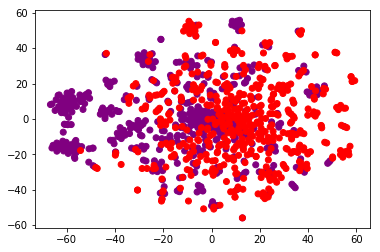

In [241]:
from matplotlib.colors import ListedColormap as ListedColormap
from matplotlib import pyplot as plt
colors = ['red','green','blue','purple']
plt.scatter(train_embedded[:,0],train_embedded[:,1],c=labels_tsne,cmap=ListedColormap(colors))
plt.show

In [46]:
train_embedded.shape

(1000, 2)

## SVM

Considerar SVC y Linear SVC. Cómo aplica 

SVC: The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

LinearSVC: Also note that for the linear case, the algorithm used in LinearSVC by the liblinear implementation is much more efficient than its libsvm-based SVC counterpart and can scale almost linearly to millions of samples and/or features.

In [242]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier # Qué es esto???


In [222]:
pred=clf.predict(tfidf_matrix_train)

In [223]:
Y_train.sum()

31624

In [224]:
pred.sum()

26991

In [225]:
Y_train.shape

(143613, 6)

In [226]:
6*143613

861678

In [227]:
np.equal(Y_train,pred).sum()/(6*143613)

0.9909351288996586

In [228]:
pred=clf.predict(tfidf_matrix_valid)

In [229]:
Y_valid.sum()

3474

In [230]:
pred.sum()

2591

In [231]:
Y_valid.shape

(15958, 6)

In [232]:
np.equal(Y_valid,pred).sum()/(6*15958)

0.9821719513723525

# Curva ROC

¿Qué pasa con esto? ¿Cómo se puede mejorar?

In [ ]:
pred_train=model_sig_nn.predict(tf_idf_train_svd)
pred_valid=model_sig_nn.predict(tf_idf_valid_svd)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

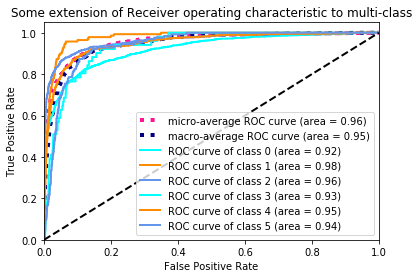

In [40]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()